In [1]:
import spacy 
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Dropout
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nlp = spacy.load("en_core_web_lg")
nlp.Defaults().stop_words.remove("n‘t")
nlp.Defaults().stop_words.remove('n’t')
nlp.Defaults().stop_words.remove('not')
nlp.Defaults().stop_words.remove('down')
nlp.Defaults().stop_words.remove('against')

data = pd.read_csv("tweets.csv")


In [2]:
data.head(3)

,company,tweet,sentiment
0,$ICICIBANK.NSE,$ICICIBANK.NSE Trade in action & Very close to...,Bullish
1,$ICICIBANK.NSE,$ICICIBANK.NSE Stock is trading with bullish m...,Bullish
2,$ICICIBANK.NSE,"$ICICIBANK.NSE \nBased on the chart analysis,...",Bullish
3,$ICICIBANK.NSE,$ICICIBANK.NSE crossed the resistance line wit...,Bullish
4,$ICICIBANK.NSE,$ICICIBANK.NSE \nThe stock is moving with the...,Bullish


In [3]:
# # data = data.drop(["clean_body", "vector", "encoded"], axis=1)
# data = data[["company", "tweet", "sentiment"]]

data['encoded'] = data.sentiment.map({
    "Bearish": 0,
    "Bullish": 1
})

data = data.loc[data["sentiment"] != 'Sentiment']
data = data.dropna()
 
data = data.reset_index(drop=True)

data = data[["company", "tweet", "sentiment", "encoded"]]

In [4]:
def preprocess_vectorize(text):
    # remove tag
    text = text[:-7].lower()
    
    # remove url
    text = re.compile(r"https?://\S+|www\.\S+").sub(r"", text)
    
    # remove \n
    text = text.replace('\n', '')

    # remove tagged usernames
    text = re.compile(r"@[^\s]+").sub(r"", text)
    
    # remove company tags
    text = re.compile(r"\$[a-zA-Z]*").sub(r"", text)
    text = re.compile(r"[0-9.]").sub(r"", text)

    text = text[4:]
    # remove unwanted spaces
    text = re.compile(r"#[A-Za-z0-9_]+").sub(r"", text)
    text = re.compile(r"  +").sub(r" ", text)
    
    
    # remove emojis and emoticons
    text = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE).sub(r"", text)
    
    

    # tokenize
    doc = nlp(text)
    doc2 = nlp("not")
    filtered_tokens = []
    for token in doc: 
        
        if token != doc2[0]: 
            filtered_tokens.append(token.lemma_)
        elif token.is_punct or token.is_stop : 
            continue
        
    
    return " ".join(filtered_tokens)


In [5]:
data['clean_body'] = data['tweet'].apply(lambda text: preprocess_vectorize(text))
data['vector'] = data['clean_body'].apply(lambda text: nlp(text).vector)
# data["vector"] = data["vector"].apply(lambda x : [float(x) for x in x.replace("[", "").replace ("]", "").split()])


In [19]:
data.head(5)

,company,tweet,sentiment,encoded,clean_body,vector
0,$ICICIBANK.NSE,$ICICIBANK.NSE Trade in action & Very close to...,Bullish,1,trade in action & very close to to the target,"[-1.9512749, 1.91589, -2.9216619, -0.5990441, ..."
1,$ICICIBANK.NSE,$ICICIBANK.NSE Stock is trading with bullish m...,Bullish,1,stock be trade with bullish momentum as it be ...,"[-2.1545355, 0.3545334, -2.230282, 2.0422037, ..."
2,$ICICIBANK.NSE,"$ICICIBANK.NSE \nBased on the chart analysis,...",Bullish,1,"base on the chart analysis , it appear that ...","[-2.5702522, 1.0234765, -1.6895349, 1.6093714,..."
3,$ICICIBANK.NSE,$ICICIBANK.NSE crossed the resistance line wit...,Bullish,1,"cross the resistance line with low volume , bu...","[-2.1902921, 1.1995242, -1.1383278, 2.5864527,..."
4,$ICICIBANK.NSE,$ICICIBANK.NSE \nThe stock is moving with the...,Bullish,1,"the stock be move with the upward trend , bu...","[-2.978768, 1.4981625, -1.0679333, 1.5351981, ..."


In [7]:
df1 = data.loc[data.sentiment == "Bullish" ] 
df2 = data.loc[data.sentiment == "Bearish" ]

df1 = df1.sample(n=len(df2))

df1 = pd.concat([df1,df2])


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(
    df1.vector.values, 
    df1.encoded,
    test_size=0.2,
    random_state=0
)
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(max_depth=10,n_estimators=10, n_jobs=-1, random_state=0)
clf1.fit(X_train_2d, y_train)
y_pred = clf1.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       524
           1       0.70      0.69      0.69       520

    accuracy                           0.70      1044
   macro avg       0.70      0.70      0.70      1044
weighted avg       0.70      0.70      0.70      1044



In [25]:
test_data = ["$RELIANCE.NSE moving towards MACD bullish crossover, once RSI is in the oversold zone, we can enter into a long position. Bullish","$RELIANCE.NSE Stock has formed a support at Ema level and may soon give a breakout in downward direction. Macd has also coincided with its signal line giving bearish signals. Bearish", "$Nifty50 has seen profit booking from the same resistance zone twice, ahead of US debt ceiling resolution. A pullback seems likely here. Which is much needed for next leg of the rally to be healthy."," $RELIANCE.NS There is a slight correction in stock price and stock is currently trading near Ema-200 level giving bullish indication.", "$TCS.NS Stock is continuously falling from past few trading sessions and has slipped below Ema-50 level today indicating bearish trend. ", "$ITC.NSE Stock hit all time high and is trading with bullish momentum as the company announced that it will close the deal to acquire Sproutlife Foods in next 3 to 4 years.", "$ICICI.NSE Stock hit all time high and is trading with bullish momentum as the company announced that it will close the deal to acquire Sproutlife Foods in next 3 to 4 years.", "$HDFCBANK.NSE Showing divergence with RSI on i30, can expect a short correction from CMP 1638/1640", "$WIPRO.NSE Stock has moved out of the range after consolidation of 2 weeks. As I said just hold it for longer period of time. Don't miss the opportunity.", "$NIFTYBANK Confirmation of downside reversal will come when Bank Nifty break down 42600 Spot." ]

for i in test_data: 
    k = np.stack([nlp(preprocess_vectorize(i)).vector])
    print(clf1.predict(k))

[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]


In [9]:
test_data = ["$RELIANCE.NSE Stock has formed a support at Ema level and may soon give a breakout in downward direction. Macd has also coincided with its signal line giving bearish signals. Bearish","$RELIANCE.NSE moving towards MACD bullish crossover, once RSI is in the oversold zone, we can enter into a long position. Bullish"]
print(preprocess_vectorize(test_data[0]))
print(preprocess_vectorize(test_data[1]))

stock have form a support at ema level and may soon give a breakout in downward direction macd have also coincide with its signal line give bearish signal
move towards macd bullish crossover , once rsi be in the oversold zone , we can enter into a long position


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense((300)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((201), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((201), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(X_train_2d, y_train, epochs=125, validation_data=(X_test_2d, y_test), verbose=2)

Epoch 1/125
131/131 - 1s - loss: 0.7708 - accuracy: 0.5407 - val_loss: 0.6382 - val_accuracy: 0.6437 - 1s/epoch - 11ms/step
Epoch 2/125
131/131 - 0s - loss: 0.6634 - accuracy: 0.6114 - val_loss: 0.6198 - val_accuracy: 0.6485 - 425ms/epoch - 3ms/step
Epoch 3/125
131/131 - 0s - loss: 0.6287 - accuracy: 0.6351 - val_loss: 0.5781 - val_accuracy: 0.6877 - 446ms/epoch - 3ms/step
Epoch 4/125
131/131 - 0s - loss: 0.5966 - accuracy: 0.6677 - val_loss: 0.5720 - val_accuracy: 0.6992 - 430ms/epoch - 3ms/step
Epoch 5/125
131/131 - 0s - loss: 0.5710 - accuracy: 0.6943 - val_loss: 0.5443 - val_accuracy: 0.7213 - 455ms/epoch - 3ms/step
Epoch 6/125
131/131 - 0s - loss: 0.5423 - accuracy: 0.7120 - val_loss: 0.5468 - val_accuracy: 0.7395 - 453ms/epoch - 3ms/step
Epoch 7/125
131/131 - 0s - loss: 0.5196 - accuracy: 0.7262 - val_loss: 0.5271 - val_accuracy: 0.7529 - 466ms/epoch - 4ms/step
Epoch 8/125
131/131 - 0s - loss: 0.5244 - accuracy: 0.7271 - val_loss: 0.5346 - val_accuracy: 0.7356 - 397ms/epoch - 3ms

In [20]:
test_data = ["$RELIANCE.NSE moving towards MACD bullish crossover, once RSI is in the oversold zone, we can enter into a long position. Bullish","$RELIANCE.NSE Stock has formed a support at Ema level and may soon give a breakout in downward direction. Macd has also coincided with its signal line giving bearish signals. Bearish", "$Nifty50 has seen profit booking from the same resistance zone twice, ahead of US debt ceiling resolution. A pullback seems likely here. Which is much needed for next leg of the rally to be healthy."," $RELIANCE.NS There is a slight correction in stock price and stock is currently trading near Ema-200 level giving bullish indication.", "$TCS.NS Stock is continuously falling from past few trading sessions and has slipped below Ema-50 level today indicating bearish trend. ", "$ITC.NSE Stock hit all time high and is trading with bullish momentum as the company announced that it will close the deal to acquire Sproutlife Foods in next 3 to 4 years.", "$ICICI.NSE Stock hit all time high and is trading with bullish momentum as the company announced that it will close the deal to acquire Sproutlife Foods in next 3 to 4 years.", "$HDFCBANK.NSE Showing divergence with RSI on i30, can expect a short correction from CMP 1638/1640", "$WIPRO.NSE Stock has moved out of the range after consolidation of 2 weeks. As I said just hold it for longer period of time. Don't miss the opportunity.", "$NIFTYBANK Confirmation of downside reversal will come when Bank Nifty break down 42600 Spot." ]
for i in test_data: 
    k = np.stack([nlp(preprocess_vectorize(i)).vector])
    print(model.predict(k) > 0.5)

1/1 [==============================] - 0s 25ms/step
[[ True]]
1/1 [==============================] - 0s 18ms/step
[[False]]
1/1 [==============================] - 0s 18ms/step
[[False]]
1/1 [==============================] - 0s 17ms/step
[[ True]]
1/1 [==============================] - 0s 17ms/step
[[False]]
1/1 [==============================] - 0s 18ms/step
[[ True]]
1/1 [==============================] - 0s 19ms/step
[[ True]]
1/1 [==============================] - 0s 19ms/step
[[False]]
1/1 [==============================] - 0s 18ms/step
[[False]]
1/1 [==============================] - 0s 23ms/step
[[False]]


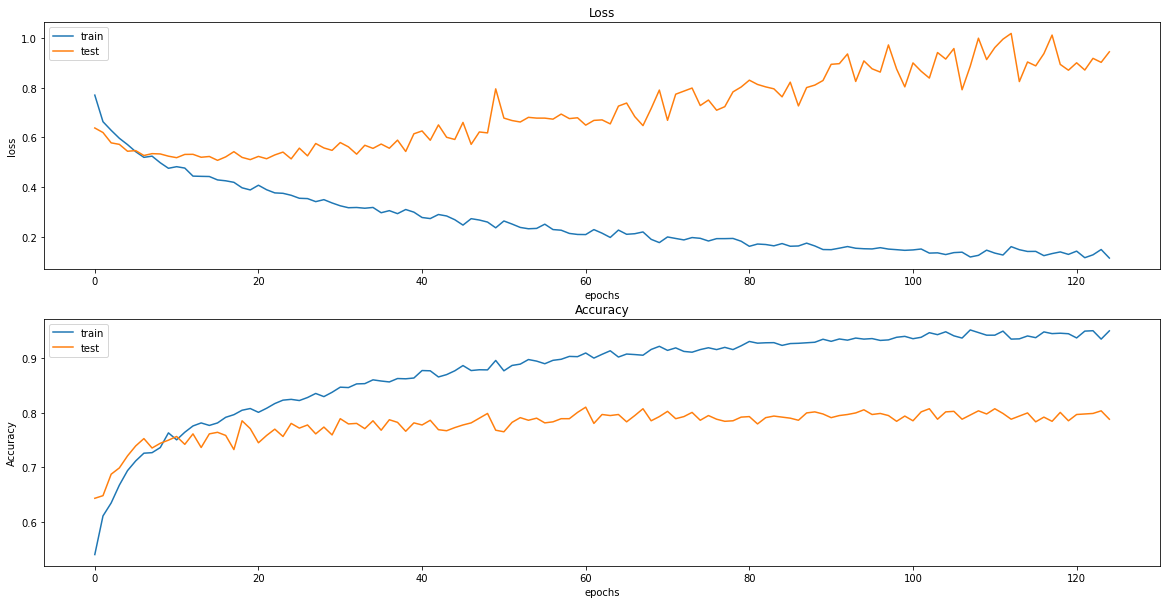

In [12]:
train_acc = model.evaluate(X_train_2d, y_train, verbose=0)
test_acc = model.evaluate(X_test_2d, y_test, verbose=0)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
df1.head()

,Unnamed: 0,company,tweet,sentiment,encoded,clean_body,vector
1580,1580,$RELIANCE.NSE,$RELIANCE.NSE #TradeIdeaIndia @StocktwitsIndia...,Bullish,1,it have bounce back take support of day ema ...,"[-1.5222052, 1.9625624, -2.343103, 0.27865103,..."
2655,2655,$TCS.NSE,$TCS.NSE \nAfter making double bottom pattern...,Bullish,1,after make double bottom pattern and give go...,"[-2.4048514, 0.85028499, -2.0487165, 2.3406227..."
8469,8469,$NIFTYBANK.NSE,Sector in momentum which could lead rally toda...,Bullish,1,or in momentum which could lead rally today be...,"[-0.93992984, 2.2525754, -2.8523405, 0.1269986..."
2472,2472,$HDFCBANK.NSE,$HDFCBANK.NSE \nMACD: 16.80 \nMacd Signal: 21...,Bullish,1,macd : macd signal : ( bullish ) rsi : ( neu...,"[-2.1945243, -2.9672077, 6.785424, 1.4355822, ..."
6298,6298,$INFY.NSE,$INFY.NSE \nCMP: Rs 1525.90 \nThe stock made ...,Bullish,1,cmp : rs the stock make the resistance at em...,"[-1.32495236, 0.797413468, -0.898868561, 1.255..."


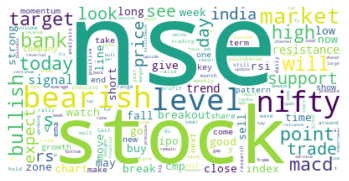

In [13]:
text = " ".join(str(tweet) for tweet in df1.clean_body)
wordcloud = WordCloud(collocations=False, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
from keras.models import load_model
model.save('model.h5')
model_final = load_model('model.h5')

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


yhat_probs = model.predict(X_test_2d, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict(X_test_2d) > 0.5
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
y_test1 = y_test > 0.5
accuracy = accuracy_score(y_test1, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

33/33 [==============================] - 0s 2ms/step
Accuracy: 0.788314
Precision: 0.813417
Recall: 0.746154
F1 score: 0.778335
ROC AUC: 0.865076
[[435  89]
 [132 388]]


In [ ]:
cc= pd.read_csv("val_counts.csv")
cc = cc.astype({"count": int})
sum = 0
for i in cc["count"]: 
    sum = sum + i
           
cc = cc.set_index('company')
cc.plot(kind="bar")
plt.title('Tweet count per company')
plt.xlabel("company")
plt.ylabel("tweet count")